In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from transformers import DebertaTokenizer, DebertaModel, DebertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [59]:
summaries_train = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
prompt_train = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')

In [3]:
train_data, val_data = train_test_split(summaries_train, test_size=0.2, random_state=42)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length,mode="train"):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mode = mode
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        text = item['text']
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        if self.mode =="train":
            content_label = torch.tensor(item['content'], dtype=torch.float32)
            wording_label = torch.tensor(item['wording'], dtype=torch.float32)
            return {
                'input_ids': inputs['input_ids'].flatten(),
                'attention_mask': inputs['attention_mask'].flatten(),
                'content_label': content_label,
                'wording_label': wording_label
            }
        elif self.mode=="test":
            return {
                'input_ids': inputs['input_ids'].flatten(),
                'attention_mask': inputs['attention_mask'].flatten(),
            }
      


tokenizer = DebertaTokenizer.from_pretrained('/kaggle/input/hugging-face-models-safe-tensors/deberta-base')

max_length = 256
train_dataset = CustomDataset(train_data, tokenizer, max_length,mode="train")
val_dataset = CustomDataset(val_data, tokenizer, max_length, mode="train")

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    content_label = [item['content_label'] for item in batch]
    wording_label = [item['wording_label'] for item in batch]
    
    max_length = max(len(ids) for ids in input_ids)
    padded_input_ids = torch.zeros((len(input_ids), max_length), dtype=torch.long)
    padded_attention_mask = torch.zeros((len(input_ids), max_length), dtype=torch.long)
    
    for i, (ids, mask) in enumerate(zip(input_ids, attention_mask)):
        padding_length = max_length - len(ids)
        padded_input_ids[i, :len(ids)] = ids
        padded_attention_mask[i, :len(mask)] = mask
    
    return {
        'input_ids': padded_input_ids,
        'attention_mask': padded_attention_mask,
        'content_label': torch.stack(content_label),
        'wording_label': torch.stack(wording_label)
    }

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [5]:
# DeBERTa
class DeBERTaForRegression(nn.Module):
    def __init__(self):
        super(DeBERTaForRegression, self).__init__()
        self.deberta = DebertaForSequenceClassification.from_pretrained('/kaggle/input/hugging-face-models-safe-tensors/deberta-base', num_labels=2)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = DeBERTaForRegression().to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# criterion = nn.MSELoss()

In [7]:
deberta_model = torch.load('/kaggle/input/deberta-commonlit-pretrained-model/deberta_trained1')

In [ ]:
deberta_model.eval()
val_predictions = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = deberta_model(input_ids=input_ids, attention_mask=attention_mask)
        content_pred, wording_pred = outputs[0].tolist()
        student_id = val_data.iloc[len(val_predictions)]['student_id']
        val_predictions.append([student_id, content_pred, wording_pred])

# Feature Engineering

In [60]:
train_merge = pd.merge(summaries_train, prompt_train, on='prompt_id')
train_merge.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   
2  0095993991fe    814d6b  The third wave only started as an experiment w...   
3  00c20c6ddd23    814d6b  The experimen was orginally about how even whe...   
4  00d40ad10dc9    814d6b  The third wave developed so quickly due to the...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1  3.272894  3.219757  Summarize how the Third Wave developed over su...   
2  0.205683  0.380538  Summarize how the Third Wave developed over su...   
3  0.567975  0.969062  Summarize how the Third Wave developed over su...   
4 -0.910596 -0.081769  Summarize how the Third Wave developed over su...   

     prompt_title                                        prompt_text  
0  The Third Wave  Background \r\nThe Third Wave experiment took ...  
1  The Third Wave  Background \r\nThe Third Wave experiment took ...  
2  The Third Wave  Background \r\nThe Third Wave experiment took ...  
3  The Third Wave  Background \r\nThe Third Wave experiment took ...  
4  The Third Wave  Background \r\nThe Third Wave experiment took ...

In [61]:
X_train, X_test, y_train, y_test = train_test_split(train_merge.drop(['content','wording'], axis=1), 
                                                    train_merge[['content','wording']], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [10]:
# pd.DataFrame({'index': y_test.index.values}).to_csv('val_index.csv', index=False)

In [15]:
#pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 30.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import Counter
from spellchecker import SpellChecker
import re
import string
from tqdm import tqdm
import spacy
from sklearn.preprocessing import StandardScaler


tqdm.pandas()

nltk.download('stopwords')
nltk.download('punkt')

nlp = spacy.load('en_core_web_sm')

In [62]:
# Main idea of preprocessor is to capture the relation between prompt and summary as much as possible
# since this relationship is neglected in the roberta training model
class Preprocess:
    def __init__(self, df):
        self.spellchecker = SpellChecker() 
        self.dataframe = df
        self.index = df.index.values
    
# ================================================================
# SUPPORT FUNCTIONS 

    def remove_punct(self,text):
        return re.sub(r'[^\w\s]', '', text)

    def remove_stopwords(self,text):

        words = word_tokenize(text)

        # Get the English stop words
        stop_words = set(stopwords.words('english'))

        # Remove stop words
        filtered_words = [word for word in words if word.lower() not in stop_words]

        # Join the filtered words back into a sentence
        filtered_text = ' '.join(filtered_words)

        return filtered_text
    
# ================================================================


# ================================================================
# TRANSFORMATION FUNCTIONS

    # count of words in summary
    def summary_text_count(self,row):
        tokenized_text = word_tokenize(row['text'])
        return len(tokenized_text)

    # word length of summary/word length of prompt
    def summary_prompt_length_ratio(self,row):
        prompt_length = len(word_tokenize(row['prompt_text']))
        return row['summary_text_count'] / prompt_length

    # unigram overlap (1 gram) between summary and prompt
    def unigram_overlap(self,row):
        prompt_tokens = word_tokenize(self.remove_stopwords(self.remove_punct(row['prompt_text'])))
        summary_tokens = word_tokenize(self.remove_stopwords(self.remove_punct(row['text'])))
        
        # Calculate the number of common n-grams
        common_ngrams = set(prompt_tokens).intersection(set(summary_tokens))

        prompt_ngram_freq = Counter(prompt_tokens)
        summary_ngram_freq = Counter(summary_tokens)
        unigram_score = 0
        for ngram in common_ngrams:
            unigram_score += prompt_ngram_freq[ngram] * summary_ngram_freq[ngram] / sum(prompt_ngram_freq.values())
        return unigram_score
    
    # bigram overlap (2 gram) between summary and prompt
    def bigram_overlap(self,row):
        prompt_tokens = word_tokenize(row['prompt_text'])
        summary_tokens = word_tokenize(row['text'])

        # Generate n-grams for the original text and summary
        prompt_ngrams = list(ngrams(prompt_tokens, 2))
        summary_ngrams = list(ngrams(summary_tokens, 2))
        # Calculate the number of common n-grams
        common_ngrams = set(prompt_ngrams).intersection(set(summary_ngrams))
        prompt_ngram_freq = Counter(prompt_ngrams)
        summary_ngram_freq = Counter(summary_ngrams)
        bigram_score = 0
        for ngram in common_ngrams:
            bigram_score += prompt_ngram_freq[ngram] * summary_ngram_freq[ngram] / sum(prompt_ngram_freq.values())
        return bigram_score
    
    # trigram overlap (3 gram) between summary and prompt
    def trigram_overlap(self,row):
        prompt_tokens = word_tokenize(row['prompt_text'])
        summary_tokens = word_tokenize(row['text'])

        # Generate n-grams for the original text and summary
        prompt_ngrams = list(ngrams(prompt_tokens, 3))
        summary_ngrams = list(ngrams(summary_tokens, 3))
        # Calculate the number of common n-grams
        common_ngrams = set(prompt_ngrams).intersection(set(summary_ngrams))

        prompt_ngram_freq = Counter(prompt_ngrams)
        summary_ngram_freq = Counter(summary_ngrams)
        
        trigram_score = 0
        for ngram in common_ngrams:
            trigram_score += prompt_ngram_freq[ngram] * summary_ngram_freq[ngram] / sum(prompt_ngram_freq.values())
        return trigram_score
    
    
    # how many unique vocab student used relative to total vocab
    def vocab_uniqueness(self, row):
        summary_tokens = word_tokenize(self.remove_stopwords(self.remove_punct(row['text'])))

        non_stopword_count = list(summary_tokens)
        unique_count = set(summary_tokens)

        return len(unique_count) / len(non_stopword_count)
    
    # return score of NER co occurence between summary and prompt
    def NER_co_occurrence(self, row):

        # Apply NER to the texts
        summary = nlp(row['text'])
        prompt = nlp(row['prompt_text'])

        # Extract the named entities from each text
        summary_entities = [ent.text for ent in summary.ents]
        prompt_entities = [ent.text for ent in prompt.ents]

        # Find the overlap between the named entities
        ent_overlap = set(summary_entities).intersection(set(prompt_entities))

        # Count the occurrences of each named entity in the overlap
        summary_ent_freq = Counter(summary_entities)
        prompt_ent_freq = Counter(prompt_entities)
        
        ent_score = 0
        for ent in ent_overlap:
            ent_score += prompt_ent_freq[ent] * summary_ent_freq[ent] / sum(prompt_ent_freq.values())

        return ent_score
        
        
    # count the number of misspelled word
    def spelling_error(self, row):
        wordlist=row['text'].split(' ')
        amount_miss = len(list(self.spellchecker.unknown(wordlist)))
        return amount_miss
    
    # number of quotes in summary
    def quote_count(self, row):
        summary = row['text']
        text = row['prompt_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        if len(quotes_from_summary)>0:
            return [quote in text for quote in quotes_from_summary].count(True)
        else:
            return 0
        
    
    # create a part of speech counting dataframe 
    def pos_tagging(self, df):
        def count_pos_tags(text):
            tokens = word_tokenize(text)
            tokens_without_punctuations = [word for word in tokens if word not in string.punctuation]
            pos_tags = pos_tag(tokens_without_punctuations)
            pos_counts = nltk.FreqDist(tag for word, tag in pos_tags)
            return pos_counts

        pos_counts_df = df['text'].progress_apply(count_pos_tags).apply(pd.Series)
        pos_counts_df = pos_counts_df.fillna(0)
        
        # include only these tags
        pos_included_tags = ['DT', 'JJ', 'NN', 'VBD', 'VB', 'WRB', 'NNS', 'TO', 'CD', 'PRP', 'IN',
               'VBP', 'WDT', 'VBZ', 'CC', 'VBG', 'JJR', 'RB', 'NNP', 'JJS', 'VBN',
               'EX', 'MD', 'PRP$', 'POS', 'WP', 'RBR', ':']
        
        # limit columns to only be the ones in the list, and if the columns are are in the original df, fill them all in with zeros
        pos_counts_df = pos_counts_df.filter(items=pos_included_tags).reindex(columns=pos_included_tags, fill_value=0)

        # Concatenate the new DataFrame with the original one
        result_df = pd.concat([df, pos_counts_df], axis=1)
        
        return result_df
# ================================================================


# ================================================================
# Run all the appropriate functions

    def run(self):
        # step 1: summary_text_count
        self.dataframe['summary_text_count'] = self.dataframe.progress_apply(self.summary_text_count, axis=1)
        
        # step 2: summary_prompt_length_ratio
        self.dataframe['summary_prompt_length_ratio'] = self.dataframe.progress_apply(self.summary_prompt_length_ratio, axis=1)
        
        # step 3: ngram_overlap
        self.dataframe['unigram_overlap'] = self.dataframe.progress_apply(self.unigram_overlap, axis=1)
        self.dataframe['bigram_overlap'] = self.dataframe.progress_apply(self.bigram_overlap, axis=1)
        self.dataframe['trigram_overlap'] = self.dataframe.progress_apply(self.trigram_overlap, axis=1)

        # step 4: spelling
        self.dataframe['spelling_error'] = self.dataframe.progress_apply(self.spelling_error, axis=1)
        
        # step 5: quote count
        self.dataframe['quote_count'] = self.dataframe.progress_apply(self.quote_count, axis=1)
        
        # step 6: vocab_uniqueness
        self.dataframe['vocab_uniqueness'] = self.dataframe.progress_apply(self.vocab_uniqueness, axis=1)

        # step 7: NER_co_occurrence
        self.dataframe['NER_co_occurrence'] = self.dataframe.progress_apply(self.NER_co_occurrence, axis=1)
        
        # step 8: pos_tagging concat
        self.dataframe = self.pos_tagging(self.dataframe)
        
        # step 9: extract/drop necessary features
        self.dataframe.drop(['student_id','prompt_id', 'text', 'prompt_question', 'prompt_title', 'prompt_text'], axis=1, inplace=True)
        
        # step 10: standard scaler
        scaler = StandardScaler()
        scaler.fit(self.dataframe)
        scaled_data = scaler.transform(self.dataframe)
        scaled_df = pd.DataFrame(scaled_data, columns=self.dataframe.columns, index=self.index)
        
        return scaled_df

In [63]:
X_train_preprocessed = Preprocess(X_train.copy()).run()

100%|██████████| 5732/5732 [00:36<00:00, 156.99it/s]


In [66]:
X_test_preprocessed = Preprocess(X_test.copy()).run()

100%|██████████| 1433/1433 [00:09<00:00, 157.60it/s]


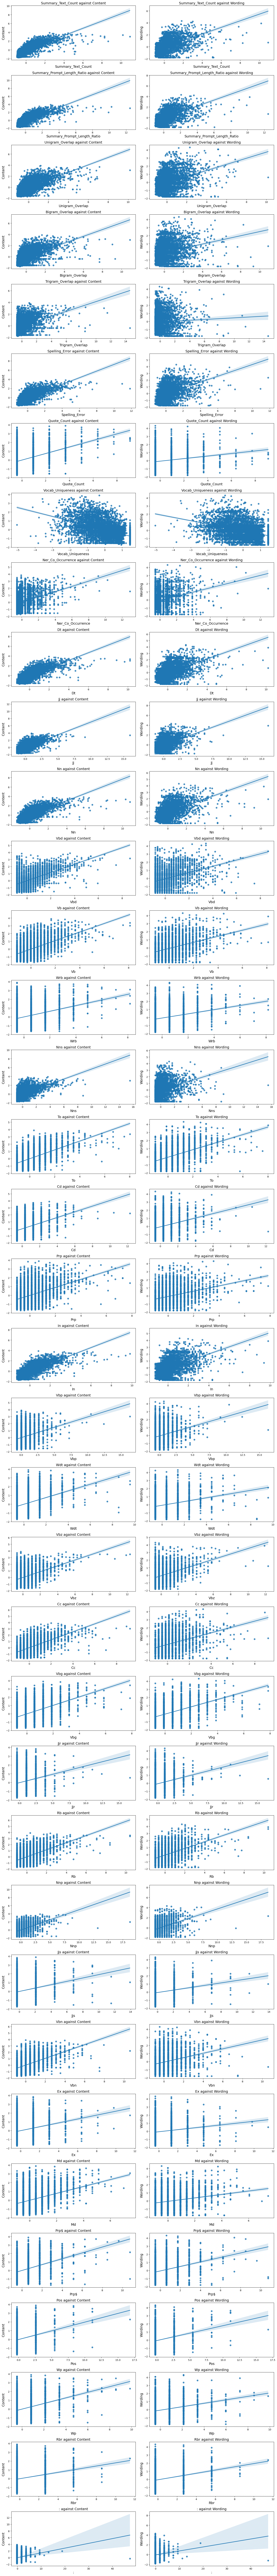

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def plot_distribution(df, target):
    num_rows = len(df.columns)
    num_cols = len(target.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 4*num_rows))

    for i, col_name in enumerate(df.columns):
        for j, target_name in enumerate(target.columns):
            ax = axes[i, j]
            sns.regplot(x=df[col_name], y=target[target_name], ax=ax)

            ax.set_title(f'{col_name.title()} against {target_name.title()}', fontsize=14)
            ax.set_xlabel(col_name.title(), fontsize=14)
            ax.set_ylabel(target_name.title(), fontsize=14)

    plt.tight_layout()
    plt.show()
    
plot_distribution(X_train_preprocessed, y_train)

In [79]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

Ridgeht = GridSearchCV(Ridge(),{ #The model you are trying to tune
    'alpha': [1,10,15,20], #Parameters that you want to test inside the list
},cv=10 #number of cross validation
 ,return_train_score=False)

Ridgeht.fit(X_train_preprocessed,y_train) #Your X and y

yhat = Ridgeht.predict(X_test_preprocessed)
print(mean_squared_error(y_test, yhat))
print(Ridgeht.best_estimator_)

0.38262286981449145
Ridge(alpha=15)


In [98]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#Build the model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=4,
                       learning_rate=0.01,
                       alpha=0.5,
                       reg_lambda=1.0)
reg.fit(X_train_preprocessed, y_train,
        eval_set=[(X_train_preprocessed, y_train), (X_test_preprocessed, y_test)],
        verbose=100)

yhat2 = reg.predict(X_test_preprocessed)

#Calculate score with mean_squared_error
print(mean_squared_error(y_test, yhat2))

# After hyperparameter tuning
# {'alpha': 0.5,
#  'gamma': 0,
#  'lambda': 1.0,
#  'learning_rate': 0.01,
#  'max_depth': 4,
#  'n_estimators': 1000}

[15:00:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.16731	validation_1-rmse:1.14566
[100]	validation_0-rmse:0.69465	validation_1-rmse:0.68080
[200]	validation_0-rmse:0.56657	validation_1-rmse:0.56761
[300]	validation_0-rmse:0.52650	validation_1-rmse:0.54152
[400]	validation_0-rmse:0.50714	validation_1-rmse:0.53293
[500]	validation_0-rmse:0.49569	validation_1-rmse:0.52913
[600]	validation_0-rmse:0.48698	validation_1-rmse:0.52685
[700]	validation_0-rmse:0.47992	validation_1-rmse:0.52542
[800]	validation_0-rmse:0.47340	validation_1-rmse:0.52446
[900]	validation_0-rmse:0.46731	validation_1-rmse:0.52369
[999]	validation_0-rmse:0.46191	validation_1-rmse:0.52331
0.2738514773233516


In [91]:
# param_grid = {
#     'learning_rate': [0.1, 0.01],
#     'n_estimators': [500,1000],
#     'max_depth': [4,5],
#     'gamma': [0, 1],
#     'alpha': [0, 0.1, 0.5],
#     'lambda': [0, 0.1, 1.0]
# }


# # Perform grid search with cross-validation
# xgbht = GridSearchCV(xgb.XGBRegressor(), 
#                      param_grid, 
#                      scoring='neg_mean_squared_error', 
#                      cv=3,
#                      verbose=100)
# xgbht.fit(X_train_preprocessed, y_train)

# # Get the best hyperparameters and model
# best_params = xgbht.best_params_
# best_model = xgbht.best_estimator_

# # Evaluate the best model on the test set
# yhat2 = best_model.predict(X_test_preprocessed)
# mse = mean_squared_error(y_test, yhat2)
# print(f"Best Model MSE: {mse}")

# # Print the best hyperparameters
# print("Best Hyperparameters:")
# for param, value in best_params.items():
#     print(f"{param}: {value}")

Best Model MSE: 0.2738518934297513
Best Hyperparameters:
alpha: 0.5
gamma: 0
lambda: 1.0
learning_rate: 0.01
max_depth: 4
n_estimators: 1000
